# Plot Variable $n$-Satellite Simulations

In [1]:
import Interval_Matrix_Algebra_Calculator_v0 as imac
import portion as P
import dionysus as d
import numpy as np 
from itertools import permutations

import time

import matplotlib.pyplot as plt

## Generate Simulations

In [12]:
from os_utilities import *
from orb_builder import *

orb_filenames = [] # used to keep track of what files to feed into soap

prefix = "" # earth / moon / mars

# n_list = [20] # number of satellites to sample from starlink
# n_list = [20, 40, 60, 80, 100] # number of satellites to sample from starlink
# n_list = [20, 30] # number of satellites to sample from starlink
# n = len(n_list)
n = 1000

sample_size = 1

folder = "./outputs/starlink-{}-sat-single"
# folder = "/home/zeno/Documents/repositories/nasa-2023/satParsing/outputs/starlink-30-sat-multiple"
# folder = "/home/zeno/Documents/repositories/nasa-2023/satParsing/outputs/sim-2023-02-17"

folder = folder.format(n)
folder_stats = folder + "-stats"
make_folder(folder_stats)

In [11]:
def identity_matrix(n):
    matrix = []
    for i in range(n):
        row = []
        for j in range(n):
            if i == j:
                row.append(P.closed(-P.inf, P.inf))
            else:
                row.append(P.empty())
        matrix.append(row)
    return matrix

def populate_matrix(filename):
    matrix = imac.soapConverter(filename)
    return matrix

def matrix_multiply(A, B, n):
    matrix = []
    for i in range(n):
        matrix.append([None for j in range(n)])
    
    for i in range(n):
        for j in range(n):
            prod_ij = P.empty()
            for k in range(n):
                prod_ij = prod_ij | A[i][k] & B[k][j]
            matrix[i][j] = prod_ij
    return matrix

def matrix_multiply_sym(A, B, n):
    matrix = []
    for i in range(n):
        matrix.append([None for j in range(n)])
    
    for i in range(n):
        for j in range(i, n):
            prod_ij = P.empty()
            for k in range(n):
                prod_ij = prod_ij | (A[i][k] & B[k][j])
            matrix[i][j] = prod_ij
            matrix[j][i] = prod_ij
            # print("{} - {}".format(i, j))
    return matrix
# matrix_multiply_sym(None, None, 3)
            
def matrix_multiply_entry(A, B, n, i, j):
    prod_ij = P.empty()
    for k in range(n):
        prod_ij = prod_ij | (A[i][k] & B[k][j])
    return prod_ij

        
def exponentiation(A, n, k):
    if k <= 0:
        # print("identity")
        return identity_matrix(n)
    elif k % 2 == 0:
        # print("k is even")
        return exponentiation(matrix_multiply(A, A, n), n, k / 2)
    elif k % 2 == 1:
        # print("k is odd")
        return matrix_multiply(A, exponentiation(matrix_multiply(A, A, n), n, (k - 1) / 2) , n)

def exponentiation_sym(A, n, k):
    if k <= 0:
        # print("identity")
        return identity_matrix(n)
    elif k % 2 == 0:
        # print("k is even")
        return exponentiation_sym(matrix_multiply_sym(A, A, n), n, k / 2)
    elif k % 2 == 1:
        # print("k is odd")
        return matrix_multiply_sym(A, exponentiation_sym(matrix_multiply_sym(A, A, n), n, (k - 1) / 2), n)
        
def exponentiation_list(A, n, k):
    A_powers = [identity_matrix(n), A]
    for i in range(2, k):
        A_powers.append(matrix_multiply_sym(A, A_powers[-1], n))
        print(i)
    return []

def exponentiation_entry(A, n, k, i, j):
    if k <= 0:
        return P.closed(-P.inf, P.inf)
    elif k == 1:
        return A[i][j]
    elif k == 2:
        return matrix_multiply_entry(A, A, n, i, j)
    else:
        prod_ij = P.empty()
        for l in range(n):
            prod_ij = prod_ij | (A[i][l] & exponentiation_entry(A, n, k - 1, l, j))
        return prod_ij

filename = "./outputs/sim-2023-03-22-rnd-large/starlink_1000_sats_1908-04_0 Contact Analysis.csv"
# filename = "/home/zeno/Documents/repositories/nasa-2023/satParsing/outputs/starlink-40-sat-single/starlink_40_sats_0 Contact Analysis.csv"

A = populate_matrix(filename)
# A = identity_matrix(10)
# print(A)
print(len(A))
n = len(A)
# n = 1000
# A = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
# A = [[1, 2, 3], [2, 4, 5], [3, 5, 6]]
# n = 3

# start_time = time.time()
# AA = matrix_multiply(A, A, n)
# # print(AA)
# print("matrix_multiply : {}".format(time.time() - start_time))

# start_time = time.time()
# AA = matrix_multiply_sym(A, A, n)
# # print(AA)
# print("matrix_multiply_sym : {}".format(time.time() - start_time))

i = 2
j = 5
start_time = time.time()
interval = exponentiation_entry(A, n, 2, i, j)
# print(AA[i][j])
print(interval)
print("exponentiation_entry(A, n, 2, {}, {}) : {}".format(i, j, time.time() - start_time))

# start_time = time.time()
# AAA = matrix_multiply_sym(A, AA, n)
# print("matrix_multiply_sym : {}".format(time.time() - start_time))

start_time = time.time()
interval = exponentiation_entry(A, n, 4, i, j)
# print(AAA[i][j])
print(interval)
print("exponentiation_entry(A, n, 4, {}, {}) : {}".format(i, j, time.time() - start_time))

start_time = time.time()
ij = matrix_multiply_entry(A, A, n, 1, 1)
# print(ij)
print("matrix_multiplication_ij : {}".format(time.time() - start_time))

k = 10

start_time = time.time()
AA = exponentiation(A, n, k)
# print(AA)
print("exponentiation^{} : {}".format(k, time.time() - start_time))

start_time = time.time()
AA = exponentiation_sym(A, n, k)
# print(AA)
print("exponentiation_sym^{} : {}".format(k, time.time() - start_time))

start_time = time.time()
A_powers = exponentiation_list(A, n, k)
print("exponentiation_list^{} : {}".format(k, time.time() - start_time))

print(A)

516
(0.0,86400.0)
exponentiation_entry(A, n, 2, 2, 5) : 0.029310941696166992


KeyboardInterrupt: 

## Parse Contact Analysis Reports

In [13]:
def unit_matrix(m): # , start_time, end_time
    matrix = []
    for i in range(m):
        row = []
        for j in range(m):
            row.append(P.closed(-P.inf, P.inf))
        matrix.append(row)
    return matrix

def identity_matrix(m):
    matrix = []
    for i in range(m):
        row = []
        for j in range(m):
            if i == j:
                row.append(P.closed(-P.inf, P.inf))
            else:
                row.append(P.empty())
        matrix.append(row)
    return matrix
        
n = 1000
A_list = []
B_list = []
m_list = []

folder_n = folder + "/starlink-{}-sat-multiple".format(n)
folder_n = folder + "/starlink-{}-sat-single".format(n)
folder_n = folder
for i in range(sample_size):
        
    filename = folder_n + "/starlink_{}_sats_{} Contact Analysis.csv".format(n, i)
    # filename = folder_n + "/starlink_a_{} Contact Analysis.csv".format(n, i)
    # print(filename)
    A = imac.soapConverter(filename)
    A_list.append(A)
    # filename = folder + "/starlink_b Contact Analysis.csv"
    # B = imac.soapConverter(filename)

    m = len(A)
    m_list.append(m)

    B = unit_matrix(m)
    B_list.append(B)

    print("{} : len(A_n) = {}, len(B_n) = {}, n = {}".format(i, m, len(B), n))

0 : len(A_n) = 516, len(B_n) = 516, n = 1000


## Calculate Distances

In [14]:
from distances_tvg import *

start_time = 0
end_time = 86400

## Distance on $k$-Walk TVG's

In [15]:
walk_length = 10
q = 2

x = list(range(walk_length))

A_walks = []

for i in range(sample_size):
    print("/starlink_{}_sats_{}".format(n, i))
    m = m_list[i]
    # A_walks.append([unit_matrix(m)]) # A_walks[i] = [A^0, A^1, ... A^k]
    A_walks.append([identity_matrix(m)]) # A_walks[i] = [A^0, A^1, ... A^k]
    
    A = A_list[i]
    B = B_list[i]
    m = m_list[i]
    
    # calculate powers up to walk_length
    for k in range(1, walk_length):  
        print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
        if k == 1:
            A_k = A
        else:
            A_k = matrix_multiply_sym(A_walks[i][-1], A, len(A))
        A_walks[i].append(A_k)

/starlink_1000_sats_0
	Calculating 1-Walks for 0-th 1000-Sat system
	Calculating 2-Walks for 0-th 1000-Sat system
	Calculating 3-Walks for 0-th 1000-Sat system
	Calculating 4-Walks for 0-th 1000-Sat system
	Calculating 5-Walks for 0-th 1000-Sat system
	Calculating 6-Walks for 0-th 1000-Sat system
	Calculating 7-Walks for 0-th 1000-Sat system
	Calculating 8-Walks for 0-th 1000-Sat system
	Calculating 9-Walks for 0-th 1000-Sat system


## Calculate Lifetime Matrices

In [8]:
y_lifetime_list = []
for l in range(sample_size):
    A = A_list[l]
    m = m_list[l]
    L = tvg_lifetime_matrix(A_walks[l], start_time, end_time, walk_length)
    
    y_list = []
    for i in range(0, m):
        for j in range(i + 1, m):
            y = []
            for k in range(0, walk_length):
                interval_sum = L[(k, i, j)]
                y.append(interval_sum)
            y_list.append(y)
            # ax.plot(x, y, label="{},{}".format(i, j))
        # interval_sum = L[(k, i, j)]
        # y.append(interval_sum)
        # print("L(mu^{})({}, {}) = {}".format(k, i, j, interval_sum))
    # print(len(y_list))            
    y_list_average = []
    for k in range(0, walk_length):
        average_sum = 0
        for y in y_list:
            average_sum += y[k]
        average = average_sum / len(y_list)
        y_list_average.append(average)
        
    y_lifetime_list.append(y_list_average)

## Plot Distances

./outputs/starlink-50-sat-single-stats


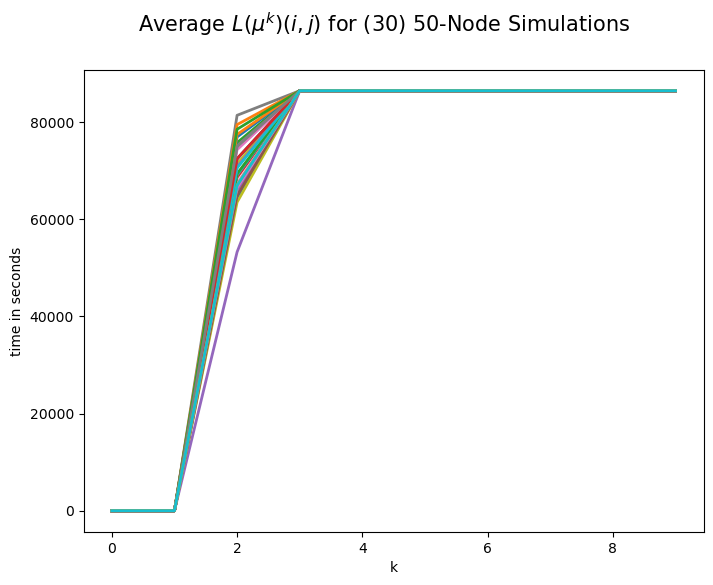

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel('k')
ax.set_ylabel('time in seconds')
fig.suptitle('Average $L(\mu^k)(i, j)$ for $({})$ ${}$-Node Simulations'.format(sample_size, n), fontsize=15)
for i in range(sample_size):
    ax.plot(x, y_lifetime_list[i], linewidth=2)
print(folder_stats)
plt.savefig(folder_stats + "/starlink_{}_sats_{}_overlay.png".format(n, sample_size))
plt.show()


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import math

# source : https://pythonguides.com/scipy-confidence-interval/
def confidence_interval(data, confidence=0.95):
    data = np.array(data)
    length = len(data)
    mean, std_error = np.mean(data), stats.sem(data)
    h = std_error * stats.t.ppf((1 + confidence) / 2.0, length - 1)
    return mean, mean - h, mean + h

def error_bars(data):
    data = np.array(data)
    length = len(data)
    mean, std = np.mean(data), np.std(data)
    error = 2 * std / math.sqrt(length)
    return mean, mean - error, mean + error
    
# data = [2, 4, 6, 3, 8, 9, 4]
# confidence_interval(data)


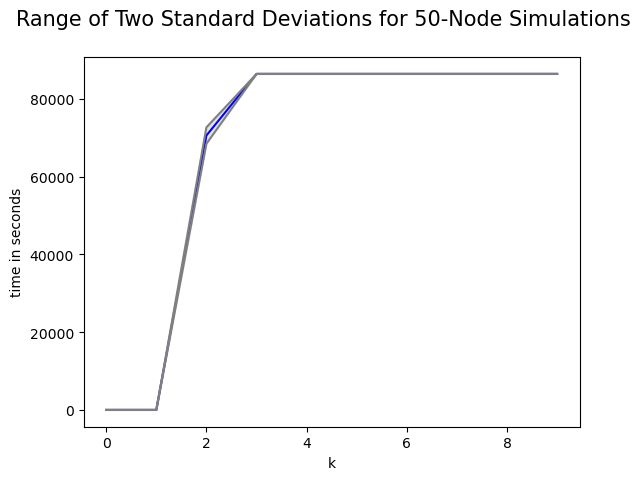

In [11]:
# following : 

x = list(range(walk_length))

lower_list = []
upper_list = []
mean_list = []

for i in range(walk_length):
    data = []
    for j in range(len(y_lifetime_list)):
        data.append(y_lifetime_list[j][i])
    # mean, lower, upper = confidence_interval(data)
    mean, lower, upper = error_bars(data)
    
    mean_list.append(mean)
    lower_list.append(lower)
    upper_list.append(upper)

fig, ax = plt.subplots()

ax.plot(x, mean_list, color="blue")
ax.plot(x, lower_list, color="grey")
ax.plot(x, upper_list, color="grey")

ax.set_xlabel('k')
ax.set_ylabel('time in seconds')
# fig.suptitle('95% Confidence Interval for {}-Node Simulations'.format(n), fontsize=15)
fig.suptitle('Range of Two Standard Deviations for {}-Node Simulations'.format(n), fontsize=15)

plt.fill_between(x, lower_list, upper_list, color='grey', alpha=0.2)

plt.savefig(folder_stats + "/starlink_{}_sats_{}_confidence.png".format(n, sample_size))
plt.show()

In [12]:
def add_vector(x):
    content = ""
    
    first = True
    for i in x:
        if first:
            prefix = ""
            first = False
        else:
            prefix = ","
        content += prefix + str(i)
        
    content += "\n"
    return content
    

def save_lineplot_csv(x, y, filepath):
    content = add_vector(x) + add_vector(y)
    
    f = open(filepath, "w")
    f.write(content)
    f.close()
    
    print(content)
    
    return None

def load_lineplot_csv(filepath):
    """
    The first line are the x-values and the second line are the y-values,
        comma-separated.
    """
    
    content = read_file(filepath)
    lines = [line.split(",") for line in content.split("\n")]

    # print(lines)
    
    x = [int(i) for i in lines[0]]
    y = [float(i) for i in lines[1]]
    
    # print(x)
    # print(y)
    
    return x, y

filepath = folder_stats + "/starlink_{}_sats_{}_confidence_mean.csv".format(n, sample_size)
save_lineplot_csv(x, mean_list, filepath)
# load_lineplot_csv(filepath)

0,1,2,3,4,5,6,7,8,9
0.0,0.0,70560.39262066782,86399.32690742084,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0



In [13]:

template = "/home/zeno/Documents/repositories/nasa-2023/satParsing/outputs/starlink-{0}-sat-single-stats/starlink_{0}_sats_{1}_confidence_mean.csv"

n_list = [5, 10, 15, 20, 25, 30, 35, 40]
mean_list = []

for i in n_list:
    filepath = template.format(i, sample_size)
    _, y = load_lineplot_csv(filepath)
    mean_list.append(y)
    
x = list(range(walk_length))

# print(x)
# print(mean_list)

labels = []

fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel('k')
ax.set_ylabel('time in seconds')
fig.suptitle('Average 95% Confidence Interval Means', fontsize=15)
for index, i in enumerate(n_list):
    labels.append("$n = {}$".format(i))
    ax.plot(x, mean_list[index], linewidth=2)
# print(folder_stats)
# plt.savefig(folder_stats + "/starlink_{}_sats_{}_overlay.png".format(n, sample_size))
plt.legend(labels)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/zeno/Documents/repositories/nasa-2023/satParsing/outputs/starlink-5-sat-single-stats/starlink_5_sats_30_confidence_mean.csv'